In [64]:
import pandas as pd
# Get player counts over time for DE and HD
steam_de = pd.read_csv('data/chart-de.csv', usecols=['DateTime', 'Players'])
steam_hd = pd.read_csv('data/chart-hd.csv', usecols=['DateTime', 'Players'])


In [221]:
display(steam_de.info())
steam_de.set_index('DateTime')
# steam_de.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 802 entries, 0 to 801
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   DateTime  802 non-null    object
 1   Players   802 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 12.7+ KB


None

,Players
DateTime,
2019-11-14 00:00:00,21797
2019-11-15 00:00:00,20594
2019-11-16 00:00:00,26163
2019-11-17 00:00:00,26767
2019-11-18 00:00:00,19596
...,...
2022-01-19 00:00:00,18799
2022-01-20 00:00:00,19254
2022-01-21 00:00:00,21395


In [222]:
display(steam_hd.info())
# Clean up the HD data:
# We have 3220 Dates but only 3166 Player values so some null values exist.
# We can impute data by interpolating player counts. Then round down fractional players and cast back to int
steam_hd.set_index('DateTime')
steam_hd.interpolate(method='linear', inplace=True)
steam_hd['Players'] = steam_hd['Players'].round()
steam_hd = steam_hd.astype({'Players': int})
# display(steam_hd.info())
steam_hd.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3220 entries, 0 to 3219
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   DateTime  3220 non-null   object
 1   Players   3220 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 50.4+ KB


None

,DateTime,Players
0,2013-04-01 00:00:00,11761
1,2013-04-02 00:00:00,11830
2,2013-04-03 00:00:00,11900
3,2013-04-04 00:00:00,11969
4,2013-04-05 00:00:00,10988


# What info do we have?
- number of players per day since release of age of empires ii: definitive edition and age of empires: hd
- limited to steam players

# What could we do with this?
- compare against other games in the age series if we get the charts for those. this could help us understand the popularity of age
- compare against other top games or other RTS games (e.g., starcraft? but that's not on steam)

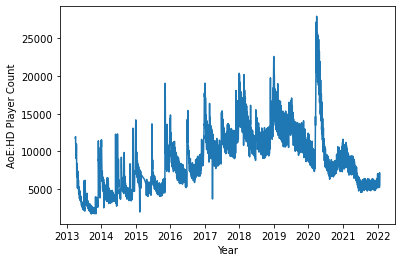

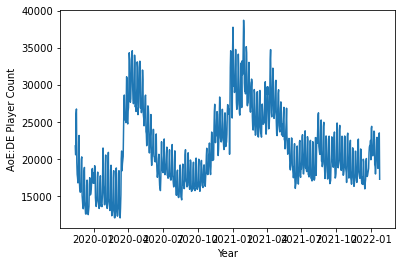

In [223]:
# Let's try to compare players in HD vs DE
# First, let's plot the two graphs then we will try to join the data and graph both together in one graph!

import matplotlib.pyplot as plt

hd_days = pd.to_datetime(steam_hd['DateTime'])
plt.plot(hd_days, steam_hd['Players'])
plt.ylabel('AoE:HD Player Count')
plt.xlabel('Year')
plt.show()

de_days = pd.to_datetime(steam_de['DateTime'])
plt.plot(de_days, steam_de['Players'])
plt.ylabel('AoE:DE Player Count')
plt.xlabel('Year')
plt.show()


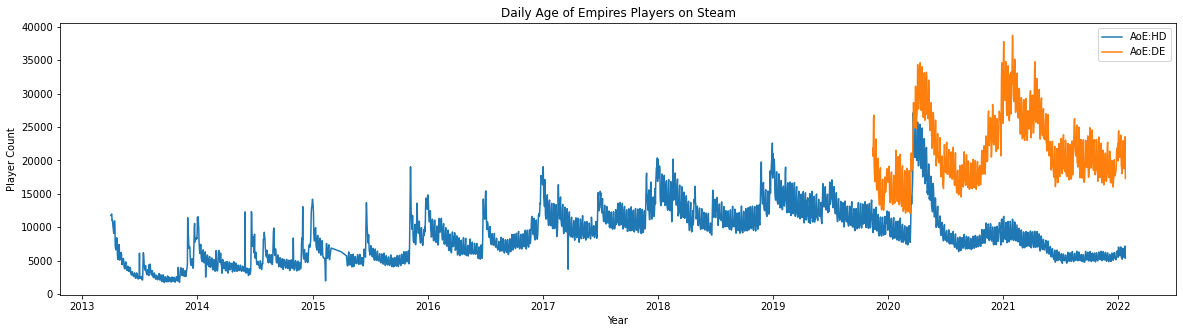

In [312]:
# Plot HD and DE together
hd_days = pd.to_datetime(steam_hd['DateTime'])
de_days = pd.to_datetime(steam_de['DateTime'])

plt.figure(figsize=(20,5))
ax = plt.subplot()
ax.plot(hd_days, steam_hd['Players'], label='AoE:HD')
ax.plot(de_days, steam_de['Players'], label='AoE:DE')
ax.legend()
plt.title('Daily Age of Empires Players on Steam')
plt.ylabel('Player Count')
plt.xlabel('Year')
plt.show()


In [300]:
# Let's try to plot the patches
patches_df = pd.read_csv('data/hd_de_patches.csv')
hd_patches = patches_df[patches_df['Game'] == 'hd']
de_patches = patches_df[patches_df['Game'] == 'de']
# display(patches_df.info())
# patches_df.head()

In [301]:
# Aside: Let's find the patches that had balance updates. We will use this later for plotting major updates to the DE game
# Note: These turn out to be for just DE as data is not labeled for HD
balance_patches = patches_df[(patches_df['Balance Changes'] != '{}') & ~(patches_df['Balance Changes'].isnull())]
balance_patches = balance_patches[['DateTime', 'Patch Number', 'Balance Changes']]
balance_patches['Patch Number'] = balance_patches['Patch Number'].astype(int)
balance_patches

# TODO check these data against the match data which has patch for each match


,DateTime,Patch Number,Balance Changes
91,2021-01-25 00:00:00,44725,{'General': ['On maps where each player begins...
93,2020-11-17 00:00:00,42848,{'General': ['Wall: Reduced the melee armor of...
98,2020-07-21 00:00:00,39284,{'General': ['Battle Elephant [Standard & Elit...
100,2020-05-28 00:00:00,37650,{'General': ['The Supplies technology is no lo...
101,2020-04-30 00:00:00,36906,{'General': ['The civilization bonuses which p...
103,2020-02-27 00:00:00,35584,{'Berbers': ['Genitour: Now receive +1 pierce ...
106,2020-01-21 00:00:00,34699,{'General': ['The Mayans and Chinese will no l...
109,2019-12-18 00:00:00,34055,{'General': ['The line-of-sight for herdable c...


In [302]:
print(f'HD had {len(hd_patches)} patches and DE had {len(de_patches)}, of which {len(balance_patches)} were balance patches')


HD had 79 patches and DE had 40, of which 8 were balance patches


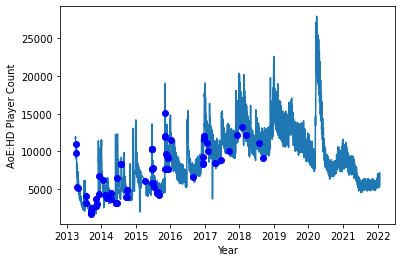

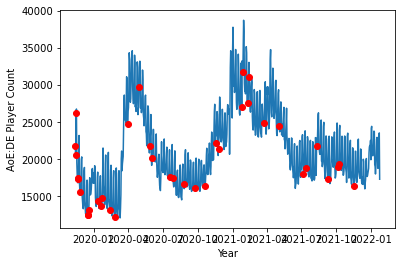

In [315]:
# Let's try and plot the patches against the game player count to see if a game update causes more players to play
hd_players_patches = pd.merge(steam_hd, hd_patches, on='DateTime')
de_players_patches = pd.merge(steam_de, de_patches, on='DateTime')
# drop the first two DE rows because we don't have DE player numbers for these from steamdb
# de_players_patches.drop([0,1], inplace=True) this isn't needed any more DELETE ME

hd_days = pd.to_datetime(steam_hd['DateTime'])
plt.plot(hd_days, steam_hd['Players'])
for patch_day in hd_players_patches['DateTime']:
    num_players = steam_hd[steam_hd['DateTime'] == patch_day]['Players'].values[0]
    plt.plot(pd.to_datetime(patch_day), num_players, 'bo')
plt.ylabel('AoE:HD Player Count')
plt.xlabel('Year')
plt.show()

de_days = pd.to_datetime(steam_de['DateTime'])
plt.plot(de_days, steam_de['Players'])
for patch_day in de_players_patches['DateTime']:
    num_players = steam_de[steam_de['DateTime'] == patch_day]['Players'].values[0]
    plt.plot(pd.to_datetime(patch_day), num_players, 'ro')
plt.ylabel('AoE:DE Player Count')
plt.xlabel('Year')
plt.show()

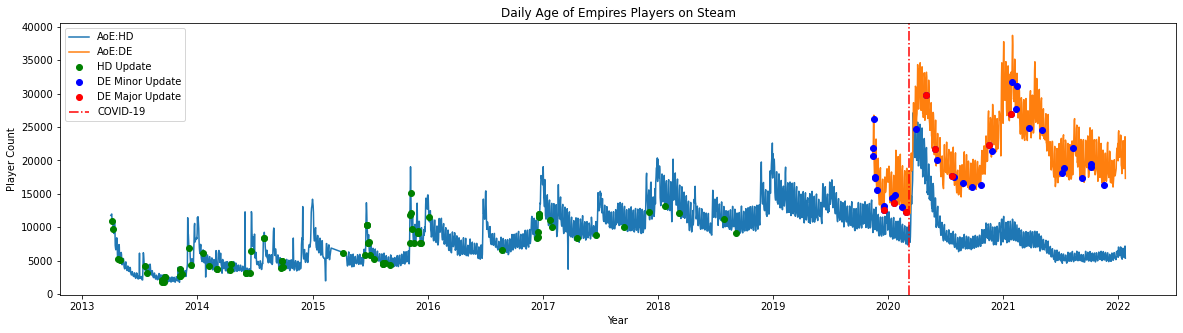

In [352]:
hd_days = pd.to_datetime(steam_hd['DateTime'])
de_days = pd.to_datetime(steam_de['DateTime'])
# de_hd_players[~de_hd_players[['DateTime']].isnull()] THIS ISNT NEEDED?

plt.figure(figsize=(20,5))
ax = plt.subplot()
ax.plot(hd_days, steam_hd['Players'], label='AoE:HD')
ax.plot(de_days, steam_de['Players'], label='AoE:DE')

created_hd_label = False
created_de_label = False
created_balance_label = False
for patch_day in hd_players_patches['DateTime']:
    num_players = steam_hd[steam_hd['DateTime'] == patch_day]['Players'].values[0]
    ax.plot(pd.to_datetime(patch_day), num_players, 'go', label='HD Update' if not created_hd_label else None)
    created_hd_label = True
for patch_day in de_players_patches['DateTime']:
    num_players = steam_de[steam_de['DateTime'] == patch_day]['Players'].values[0]
    ax.plot(pd.to_datetime(patch_day), num_players, 'bo', label='DE Minor Update' if not created_de_label else None)
    created_de_label = True
for patch_day in balance_patches['DateTime']:
    num_players = steam_de[steam_de['DateTime'] == patch_day]['Players'].values[0]
    ax.plot(pd.to_datetime(patch_day), num_players, 'ro', label='DE Major Update' if not created_balance_label else None)
    created_balance_label = True
# We see a sharp spike in March 2020, what's going on...hmm
plt.axvline(pd.to_datetime('March 7 2020'), color='red', label='COVID-19', linestyle='-.')
ax.legend()
plt.title('Daily Age of Empires Players on Steam')
plt.ylabel('Player Count')
plt.xlabel('Year')
plt.show()


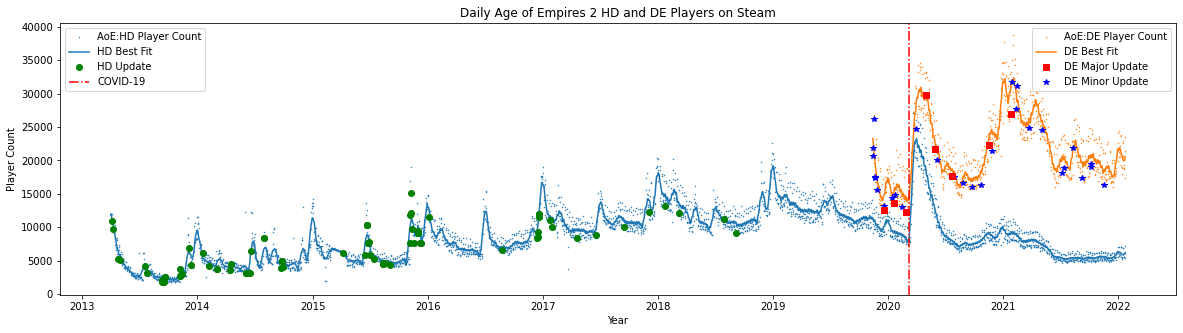

In [354]:
# The player counts jump around a lot and really this should be a scatter plot. It would be nice to make a best fit line that smooths out the data
from scipy.signal import savgol_filter

hd_days = pd.to_datetime(steam_hd['DateTime'])
de_days = pd.to_datetime(steam_de['DateTime'])

plt.figure(figsize=(20,5))
# Plot the player counts as scatter plot
hd_scatterplot = plt.scatter(hd_days, steam_hd['Players'], label='AoE:HD Player Count', s=0.25)
de_scatterplot = plt.scatter(de_days, steam_de['Players'], label='AoE:DE Player Count', s=0.25)

# Overlay the best fit lines
# https://stackoverflow.com/questions/63511090/how-can-i-smooth-data-in-python
hd_players_filtered = steam_hd[['Players']].apply(savgol_filter, window_length=31, polyorder=3)
de_players_filtered = steam_de[['Players']].apply(savgol_filter, window_length=31, polyorder=3)
hd_line, = plt.plot(hd_days, hd_players_filtered, label='HD Best Fit')
de_line, = plt.plot(de_days, de_players_filtered, label='DE Best Fit')

# Plot markers for patches
created_hd_label = False
created_de_label = False
created_balance_label = False
hd_marker = None
de_major_marker = None
de_minor_marker = None
for patch_day in hd_players_patches['DateTime']:
    num_players = steam_hd[steam_hd['DateTime'] == patch_day]['Players'].values[0]
    marker, = plt.plot(pd.to_datetime(patch_day), num_players, 'go', label='HD Update' if not created_hd_label else None)
    if not created_hd_label:
        hd_marker = marker
    created_hd_label = True
for patch_day in de_players_patches['DateTime']:
    num_players = steam_de[steam_de['DateTime'] == patch_day]['Players'].values[0]
    marker, = plt.plot(pd.to_datetime(patch_day), num_players, 'b*', label='DE Minor Update' if not created_de_label else None)
    if not created_de_label:
        de_minor_marker = marker
    created_de_label = True
for patch_day in balance_patches['DateTime']:
    num_players = steam_de[steam_de['DateTime'] == patch_day]['Players'].values[0]
    marker, = plt.plot(pd.to_datetime(patch_day), num_players, 'rs', label='DE Major Update' if not created_balance_label else None)
    if not created_balance_label:
        de_major_marker = marker
    created_balance_label = True
# We see a sharp spike in March 2020, what's going on...hmm
covid_line = plt.axvline(pd.to_datetime('March 7 2020'), color='red', label='COVID-19', linestyle='-.')

# Make two legends, one for HD and one for DE
# https://matplotlib.org/3.3.3/tutorials/intermediate/legend_guide.html#multiple-legends-on-the-same-axes
de_legend = plt.legend(handles=[de_scatterplot, de_line, de_major_marker, de_minor_marker], loc='upper right')
ax = plt.gca().add_artist(de_legend)
plt.legend(handles=[hd_scatterplot, hd_line, hd_marker, covid_line, ])

plt.title('Daily Age of Empires 2 HD and DE Players on Steam')
plt.ylabel('Player Count')
plt.xlabel('Year')
plt.show()
